<a href="https://colab.research.google.com/github/MaximeGloesener/HandsOnAI-Challenge1/blob/master/Challenge1_gdrive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Hardware Informations (GPU)**

In [65]:
!/opt/bin/nvidia-smi
!rm -rf sample_data

Wed Nov 23 20:34:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    28W /  70W |  14632MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **2. Importation des librairies**

In [66]:
from IPython.display import Image, HTML, display
from matplotlib import pyplot as plt
import numpy as np 
import os
import cv2
import csv
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.models import Model, load_model
from keras import backend as K
from keras.applications.vgg16 import VGG16, preprocess_input #224*224
from keras.applications.xception import Xception, preprocess_input, decode_predictions #299*299
from keras.applications.mobilenet import MobileNet, preprocess_input, decode_predictions #224*224
from keras.preprocessing.image import ImageDataGenerator
from keras.losses import categorical_crossentropy
from keras.layers import Dense, GlobalAveragePooling2D, Activation, Flatten, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
import math
import argparse
import matplotlib
import imghdr
import pickle as pkl
import datetime
from cycler import cycler
from PIL import Image, ImageEnhance
from google.colab import files
from tqdm import tqdm
print("Tensorflow version: "+tf.__version__)
print("Keras version: " + tf.keras.__version__)

Tensorflow version: 2.9.2
Keras version: 2.9.0


#**3. Connexion à Google Colab pour acceder aux bases de données**

In [67]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#**4. Création des labels dans le fichier "classes.txt"**

In [68]:
!printf '%s\n' 'fire' 'no_fire' 'start_fire'> classes.txt

#**5. Paramètres pour l'entrainement**

In [69]:
# Fix random seed 
tf.keras.utils.set_random_seed(42)

In [70]:
nb_classes = 3
nbr_batch_size=32 #@param [1,2,4,8,16,32,64,128] {type:"raw"}
dataset_path = "gdrive/MyDrive/Challenge1"
input_dim=224 #@param [224,299] {type:"raw"}  
dataset_name='db1' #@param ["db1","db2"]
dataset_path = os.path.join(dataset_path,dataset_name)
classes_path = "classes.txt"
csv_path = 'result.csv'
epochs = 20 #@ param {type:"slider", min:5, max:100, step:5}

result_path='results/'
log_path='logs'

classifier = "Xception" #@param ["ResNet50","VGG19","Xception","MobileNet","DenseNet169"] {type:"string"}
result_path = 'results/'+classifier
log={
    'epochs':epochs,
    'batch_size':nbr_batch_size,
    'val_loss':-1,
    'val_acc':-1,
}

In [71]:
print(dataset_path)

gdrive/MyDrive/Challenge1/db1


# **6. Nombre de classes**

In [72]:
# Get the class names
with open(classes_path, 'r') as f:
    classes = f.readlines()
    classes = list(map(lambda x: x.strip(), classes))
num_classes = len(classes)

In [73]:
print(num_classes)

3


# **8. Sélection et configuration du training dataset**

In [74]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
	dataset_path,                     	# Path of the dataset
	validation_split=0.2,             	# Data division : validation (20%), train (80%)
	subset="training",               	 	# Selection of training data
	seed=42,                          	# Initialization of random generator (for permutations)
	image_size=(input_dim,input_dim),   # Input size of images
	batch_size=nbr_batch_size,        	# Batch_size
  label_mode="categorical"     				# Conversion to One-Hot format
)

Found 3085 files belonging to 3 classes.
Using 2468 files for training.


#**9. Sélection et configuration du validation dataset**

In [75]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
	dataset_path,                     	# Path of the dataset
	validation_split=0.2,             	# Data division : validation (20%), train (80%)
	subset="validation",                # Selection of validation data
	seed=42,                          	# Initialization of random generator (for permutations)
	image_size=(input_dim,input_dim),   # Input size of images
	batch_size=nbr_batch_size,        	# Batch_size
  label_mode="categorical"     				# Conversion to One-Hot format
)

Found 3085 files belonging to 3 classes.
Using 617 files for validation.


# **10. Téléchargement du modèle pré-entraîné**

In [76]:
base_model = Xception(include_top = False, weights ='imagenet',input_shape = (input_dim,input_dim,3))
model = base_model.output
model = Flatten()(model)
model = Dense(128,activation='relu')(model)
model = Dropout(0.8)(model)
model = Dense(64,activation = 'relu')(model)
model = Dropout(0.6)(model)
predictions = Dense(num_classes, activation = 'softmax')(model)
model = Model(inputs=base_model.inputs, outputs=predictions)

# **13. Entraînement du modèle**

In [77]:
tf.keras.backend.clear_session()
# pour permettre le ré-entrainement des couches
for layer in model.layers:
    layer.trainable = True

# recompiler le modèle
opt = keras.optimizers.SGD(learning_rate=0.0001,decay=1e-6)
opt2 = keras.optimizers.Adam(lr=0.0001)
opt3 = keras.optimizers.RMSprop(learning_rate = 0.0001,decay = 1e-6)
model.compile(loss='categorical_crossentropy',optimizer=opt3,metrics=['accuracy'])  


# Création du dossier pour sauvegrader le model
if not os.path.exists(result_path):
    os.makedirs(result_path)


keras_callback = [EarlyStopping(monitor='val_loss',patience = 8, verbose = 2)]

history=model.fit(
    train_ds,
    steps_per_epoch=math.ceil(len(train_ds)),
    epochs=epochs,
    validation_data=val_ds,
    validation_steps=math.ceil(len(val_ds)),
    verbose=1,
    callbacks = keras_callback
)

Epoch 1/20
78/78 [==============================] - 68s 710ms/step - loss: 1.0976 - accuracy: 0.4931 - val_loss: 0.5385 - val_accuracy: 0.7731
Epoch 2/20
78/78 [==============================] - 60s 727ms/step - loss: 0.6181 - accuracy: 0.7443 - val_loss: 0.6085 - val_accuracy: 0.8088
Epoch 3/20
78/78 [==============================] - 60s 724ms/step - loss: 0.4064 - accuracy: 0.8493 - val_loss: 0.7515 - val_accuracy: 0.8428
Epoch 4/20
78/78 [==============================] - 59s 715ms/step - loss: 0.3083 - accuracy: 0.8922 - val_loss: 0.4908 - val_accuracy: 0.9190
Epoch 5/20
78/78 [==============================] - 60s 731ms/step - loss: 0.2449 - accuracy: 0.9060 - val_loss: 0.5291 - val_accuracy: 0.9368
Epoch 6/20
78/78 [==============================] - 59s 714ms/step - loss: 0.1848 - accuracy: 0.9323 - val_loss: 0.5594 - val_accuracy: 0.9400
Epoch 7/20
78/78 [==============================] - 59s 716ms/step - loss: 0.1751 - accuracy: 0.9412 - val_loss: 0.2952 - val_accuracy: 0.9627

#**14. Enregistrement du modèle**


In [87]:
model.save('maxnetv4.h5')

#**15. Visualisation des courbes training/validation**

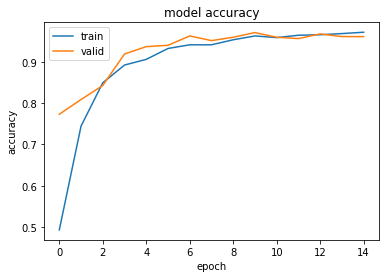

In [79]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

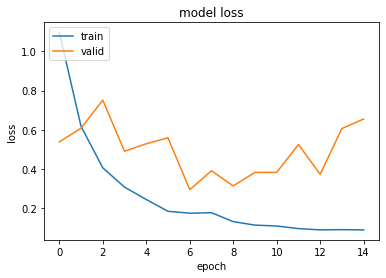

In [80]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [81]:
path_test1 = "/content/gdrive/MyDrive/Challenge1/test_data/test/Test_Dataset"
test_ds1 = tf.keras.preprocessing.image_dataset_from_directory(
	path_test1,          							# chemin vers le jeu de données
	seed=42,                    			# Initialisation du générateur aléatoire (permutations)
	image_size=(input_dim,input_dim), # Taille des images d'entrée
	batch_size=nbr_batch_size,      	# Taille du mini-batch
  label_mode='categorical'    			# Conversion au format One-Hot
)
path_test2 = "/content/gdrive/MyDrive/Challenge1/test_data/Test_Dataset2"
test_ds2 = tf.keras.preprocessing.image_dataset_from_directory(
	path_test2,          							# chemin vers le jeu de données
	seed=42,                    			# Initialisation du générateur aléatoire (permutations)
	image_size=(input_dim,input_dim), # Taille des images d'entrée
	batch_size=nbr_batch_size,      	# Taille du mini-batch
  label_mode='categorical'    			# Conversion au format One-Hot
)

Found 210 files belonging to 3 classes.
Found 300 files belonging to 3 classes.


In [82]:
def print_score(model, test_data):
  score = model.evaluate(test_data,  steps=len(test_data),workers = 1)
  print("%s: %.2f%%" % (model.metrics_names[0], score[0]))
  print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

In [86]:
print_score(model, test_ds1)
print_score(model, test_ds2)

7/7 [==============================] - 3s 120ms/step - loss: 0.4443 - accuracy: 0.9667
loss: 0.44%
accuracy: 96.67%
10/10 [==============================] - 3s 127ms/step - loss: 0.3858 - accuracy: 0.9667
loss: 0.39%
accuracy: 96.67%


#**16. Test du modèle avec une image de test**

In [84]:
filename = "https://www.ecologie.gouv.fr/sites/default/files/styles/standard/public/Feux.png"

In [85]:
%matplotlib inline
classes = train_ds.class_names
image_path =  "fog.jpg"
img = Image.open(image_path).convert('RGB')
x = tf.keras.utils.img_to_array(img,data_format='channels_last')
x = tf.keras.preprocessing.image.smart_resize(x, size=(input_dim,input_dim))
x = np.expand_dims(x, axis=0)
# predict
pred = model.predict(x,batch_size=1)[0]

for (pos,prob) in enumerate(pred):
    class_name = classes[pos]
    if (pos == np.argmax(pred)) :
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        font = cv2.FONT_HERSHEY_COMPLEX 
        textsize = cv2.getTextSize(class_name, font, 1, 2)[0]
        textX = (img.shape[1] - textsize[0]) / 2
        textY = (img.shape[0] + textsize[1]) / 2
        cv2.putText(img, class_name, (int(textX)-10, int(textY)), font, 2, (255,0,0), 6, cv2.LINE_AA)
        plt.imshow(img)
    print("Class Name : %s" % (class_name), "---", "Class Probability: %.2f%%" % (prob*100))
plt.show()

FileNotFoundError: ignored